In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap

/home/dami/anaconda3/envs/SOTA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
df = pd.read_csv("opt_2.csv")
target_col = "value"

#Drop columns datetime_start, datetime_complete, duration, state
df = df.drop(columns=["datetime_start", "datetime_complete", "duration", "state", "number"])

#Remove any rows where 'value' is greater than 1
df = df[df[target_col] <= 1]
df = df[df[target_col] >= 0]

In [3]:
#Print states of the value column
print(df[target_col].describe())

count    1628.000000
mean        0.644262
std         0.087652
min         0.519627
25%         0.555245
50%         0.643223
75%         0.686685
max         0.946083
Name: value, dtype: float64


In [4]:
df.head()

,value,params_alpha-eval,params_alpha-train,params_batch-size,params_eps-eval,params_eps-train,params_lambda-actions-eval,params_lambda-actions-train,params_lambda-frames-eval,params_lambda-frames-train,params_learning-rate,params_n-epochs,params_n-frames,params_radius-gw,params_rho,params_ub-actions,params_ub-frames,params_weight-decay
0,0.544035,0.492666,0.337545,8,0.013021,0.055598,0.033735,0.018903,0.071837,0.047613,0.052260,23,20,0.007727,0.297315,True,False,0.000512
1,0.569380,0.275010,0.378613,8,0.057696,0.079348,0.050592,0.088075,0.042449,0.006680,0.000011,30,16,0.054046,0.059368,False,True,0.000961
2,0.544035,0.201905,0.798699,8,0.015690,0.074430,0.034397,0.037924,0.012495,0.047854,0.041686,23,22,0.068546,0.168253,True,False,0.000004
3,0.597296,0.311999,0.460324,8,0.016052,0.059743,0.061367,0.076975,0.003354,0.021714,0.000048,21,22,0.023316,0.286206,False,False,0.000034
4,0.664435,0.588699,0.642640,8,0.005436,0.098069,0.023136,0.026549,0.012954,0.093852,0.064788,16,19,0.025230,0.275268,False,True,0.000069


In [5]:
features = [col for col in df.columns if col != target_col]
num_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
cat_features = df[features].select_dtypes(exclude=[np.number]).columns.tolist()

In [6]:
# First, let's check what we're working with
print("Categorical features:", cat_features)
print("Shape of categorical data:", df[cat_features].shape)

# Now let's modify the encoding step
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Changed sparse to sparse_output
# Fit and transform the categorical features
encoded_array = encoder.fit_transform(df[cat_features])
# Get the feature names
feature_names = encoder.get_feature_names_out(cat_features)
print("Encoded feature names:", feature_names)
print("Shape of encoded array:", encoded_array.shape)

# Create DataFrame with encoded features
encoded_cats = pd.DataFrame(encoded_array, columns=feature_names)

# Join with original dataframe
df = df.drop(columns=cat_features).join(encoded_cats)

# Standardize numerical features
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

# Define X and y
X = df.drop(columns=[target_col])
y = df[target_col]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Categorical features: ['params_ub-actions', 'params_ub-frames']
Shape of categorical data: (1628, 2)
Encoded feature names: ['params_ub-actions_True' 'params_ub-frames_True']
Shape of encoded array: (1628, 2)


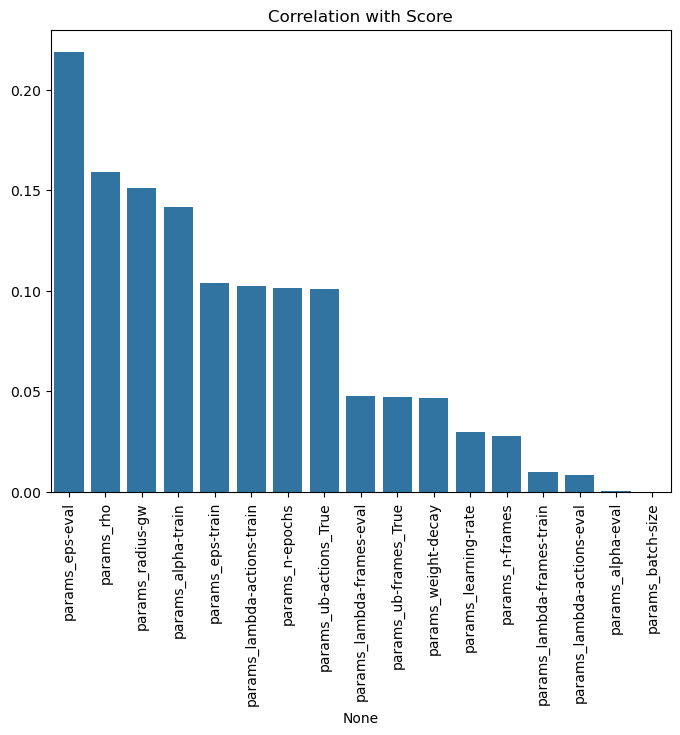

In [7]:
# 1. Correlation Analysis
corr = df.corr()[target_col].drop(target_col)
plt.figure(figsize=(8, 6))
sns.barplot(x=corr.abs().sort_values(ascending=False).index, y=corr.abs().sort_values(ascending=False).values)
plt.xticks(rotation=90)
plt.title("Correlation with Score")
plt.show()

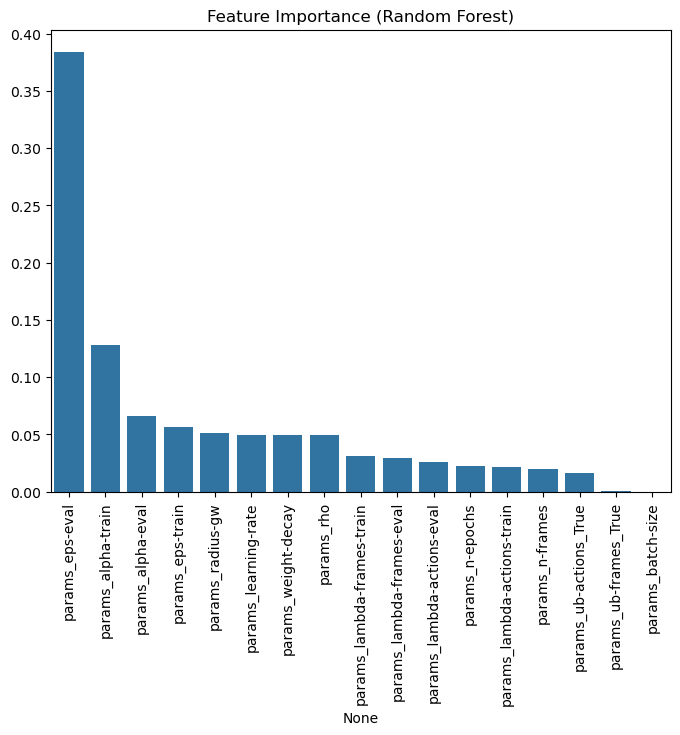

In [ ]:
# 2. Feature Importance using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

plt.figure(figsize=(8, 6))
sns.barplot(x=X.columns[np.argsort(importances)[::-1]], y=importances[np.argsort(importances)[::-1]])
plt.xticks(rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.show()

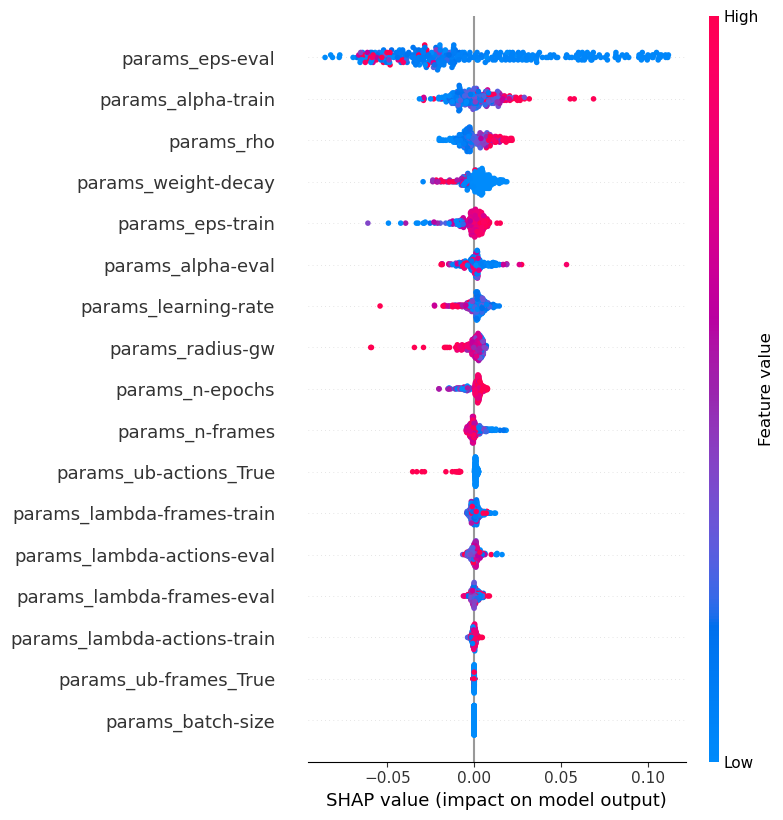

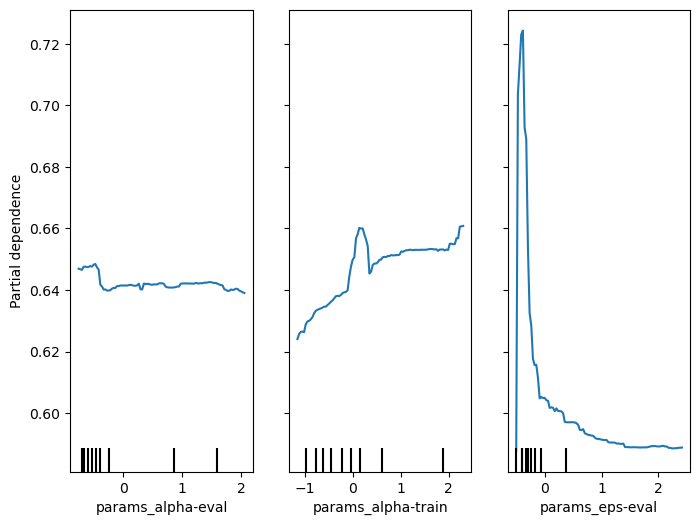

In [10]:
# 4. SHAP Analysis
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

# 5. Partial Dependence Plots
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(rf, X_train, features=np.argsort(importances)[-3:], ax=ax)
plt.show()